# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [21]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import json
from scipy.stats import linregress
from itertools import islice 
import math
from datetime import datetime
from datetime import date

# Import API key
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [2]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(low=-90.000, high=90.000, size=1500)
lngs = np.random.uniform(low=-180.000, high=180.000, size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
print(len(cities))
print(cities)

597
['verkhnevilyuysk', 'kavieng', 'kamen-na-obi', 'ushuaia', 'avarua', 'barentsburg', 'illoqqortoormiut', 'pevek', 'nikolskoye', 'mataura', 'cape town', 'carnarvon', 'saint george', 'kapaa', 'mar del plata', 'hobart', 'woodward', 'chuy', 'busselton', 'otta', 'alofi', 'liberty', 'bonavista', 'port elizabeth', 'chepareria', 'addis zemen', 'jamestown', 'morgan city', 'saint-philippe', 'hasaki', 'hermanus', 'karamea', 'beloha', 'lavrentiya', 'attawapiskat', 'turayf', 'san patricio', 'souillac', 'vila velha', 'punta arenas', 'kawalu', 'yellowknife', 'taolanaro', 'new norfolk', 'bayan', 'rikitea', 'saskylakh', 'thompson', 'san cristobal', 'san vicente', 'norman wells', 'bluff', 'saurimo', 'atuona', 'shimoda', 'bredasdorp', 'moussoro', 'pangody', 'kodiak', 'constitucion', 'flinders', 'camacari', 'tuatapere', 'jackson', 'iqaluit', 'kirkuk', 'burnie', 'vaini', 'georgetown', 'talara', 'butaritari', 'luganville', 'orlik', 'dikson', 'itabira', 'uribia', 'provideniya', 'sitka', 'vao', 'grindavik',

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [3]:
# Define function to create a dictionary containing weather data 
# for a single city, and append it to the dictionary.
def create_city_dict(city):
    # Create a list to hold weather data for a single city
    city_weather = []

    # Save config information
    url = "http://api.openweathermap.org/data/2.5/weather?"

    # Build query URL
    query_url = f"{url}appid={weather_api_key}&q={city}&units=Imperial"

    # Read JSON data to call the Open Weather Map API.
    weather_response = requests.get(query_url)
    weather_json = weather_response.json()

    # Set variables to hold relevant data
    city_name = weather_json["name"]
    lat = weather_json["coord"]["lat"]
    lon = weather_json["coord"]["lon"]
    max_temp = weather_json["main"]["temp_max"]
    cloud = weather_json["clouds"]["all"]
    wind_speed = weather_json["wind"]["speed"]
    humidity = weather_json["main"]["humidity"]
    date = weather_json["dt"]
    id_code = weather_json["id"]
    country = weather_json["sys"]["country"]

    # Append variables to list
    city_weather.append(city_name)
    city_weather.append(cloud)
    city_weather.append(country)
    city_weather.append(date)
    city_weather.append(humidity)
    city_weather.append(lat)
    city_weather.append(lon)
    city_weather.append(max_temp)
    city_weather.append(wind_speed)

    # Update all_cities_weather dictionary to include data for that city
   
    return city_weather

In [4]:
# Create a dictionary to hold each city name as a key
# and a list of city weather data as values
all_cities_weather = {}

# Perform a loop of API calls cities
try:
    # Loop through x groups of 50 cities.  
    # If number of cities is not divisible by 50, 
    # then the last group will raise an IndexError. 
    # Raise an Exception IndexError to terminate the loop.
    for x in range(0, math.floor(len(cities)/50+1)):

        # Loop through each set of 50 cities
        for y in range(0, 49):
            
            try:
                # Create a variable to hold weather data for that city.
                city = create_city_dict(cities[x*50+y])   
    
                # Update all_cities_weather dictionary to include data for that city
                all_cities_weather.update({cities[x*50+y]:city})
    
                # Print index number of city, index number of groups, and name of city
                print(f"Processing Record {y+1} of Set {x+1} | {cities[x*50+y]}")

            # If city name is not in Open Weather API list of cities, 
            # raise an Exception to print City not found.
            except KeyError:
                print("City not found. Skipping...")

        # Delay 15 seconds between API calls
        time.sleep(15)
    
    # Exception IndexError to terminate the loop.
except IndexError:
    print(f"------------------------------") 
    print(f"Data Retrieval Complete") 
    print(f"------------------------------")

Processing Record 1 of Set 1 | verkhnevilyuysk
Processing Record 2 of Set 1 | kavieng
Processing Record 3 of Set 1 | kamen-na-obi
Processing Record 4 of Set 1 | ushuaia
Processing Record 5 of Set 1 | avarua
City not found. Skipping...
City not found. Skipping...
Processing Record 8 of Set 1 | pevek
Processing Record 9 of Set 1 | nikolskoye
Processing Record 10 of Set 1 | mataura
Processing Record 11 of Set 1 | cape town
Processing Record 12 of Set 1 | carnarvon
Processing Record 13 of Set 1 | saint george
Processing Record 14 of Set 1 | kapaa
Processing Record 15 of Set 1 | mar del plata
Processing Record 16 of Set 1 | hobart
Processing Record 17 of Set 1 | woodward
Processing Record 18 of Set 1 | chuy
Processing Record 19 of Set 1 | busselton
Processing Record 20 of Set 1 | otta
Processing Record 21 of Set 1 | alofi
Processing Record 22 of Set 1 | liberty
Processing Record 23 of Set 1 | bonavista
Processing Record 24 of Set 1 | port elizabeth
Processing Record 25 of Set 1 | chepareria

Processing Record 9 of Set 5 | sabalgarh
Processing Record 10 of Set 5 | dicamay
Processing Record 11 of Set 5 | imbituba
Processing Record 12 of Set 5 | monrovia
Processing Record 13 of Set 5 | bengkulu
Processing Record 14 of Set 5 | yarim
Processing Record 15 of Set 5 | jiwani
Processing Record 16 of Set 5 | hilo
Processing Record 17 of Set 5 | raudeberg
Processing Record 18 of Set 5 | longyearbyen
Processing Record 19 of Set 5 | victor harbor
Processing Record 20 of Set 5 | kloulklubed
Processing Record 21 of Set 5 | pacifica
Processing Record 22 of Set 5 | chumikan
City not found. Skipping...
Processing Record 24 of Set 5 | paka
Processing Record 25 of Set 5 | natal
Processing Record 26 of Set 5 | puri
Processing Record 27 of Set 5 | nuuk
Processing Record 28 of Set 5 | pitimbu
Processing Record 29 of Set 5 | grand gaube
Processing Record 30 of Set 5 | lebedinyy
Processing Record 31 of Set 5 | plon
Processing Record 32 of Set 5 | axim
Processing Record 33 of Set 5 | lagoa
Processi

Processing Record 21 of Set 9 | bac lieu
Processing Record 22 of Set 9 | suez
Processing Record 23 of Set 9 | normal
City not found. Skipping...
Processing Record 25 of Set 9 | clinton
Processing Record 26 of Set 9 | barra
Processing Record 27 of Set 9 | lompoc
Processing Record 28 of Set 9 | le port
Processing Record 29 of Set 9 | quatre cocos
Processing Record 30 of Set 9 | arona
Processing Record 31 of Set 9 | sabang
Processing Record 32 of Set 9 | plettenberg bay
Processing Record 33 of Set 9 | chaykovskaya
Processing Record 34 of Set 9 | bathsheba
Processing Record 35 of Set 9 | rudbar
Processing Record 36 of Set 9 | komsomolskiy
Processing Record 37 of Set 9 | avera
Processing Record 38 of Set 9 | brigantine
Processing Record 39 of Set 9 | narsaq
Processing Record 40 of Set 9 | jiayuguan
Processing Record 41 of Set 9 | swindon
Processing Record 42 of Set 9 | andenes
Processing Record 43 of Set 9 | chandbali
Processing Record 44 of Set 9 | polovinnoye
City not found. Skipping...
P

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [12]:
# Convert all_cities_weather dictionary to a DataFrame
Summary = pd.DataFrame.from_dict(all_cities_weather, orient="index")

# Rename the DataFrame columns
Summary = Summary.rename(columns=
                        {0:"City",
                        1:"Cloudiness",
                        2:"Country",
                        3:"Date",
                        4:"Humidity",
                        5:"Lat",
                        6:"Lng",
                        7:"Max Temp",
                        8:"Wind Speed"}
                        )
# Reset index.
Summary = Summary.reset_index(drop=True)

# Display head
Summary.head()

,City,Cloudiness,Country,Date,Humidity,Lat,Lng,Max Temp,Wind Speed
0,Verkhnevilyuysk,97,RU,1584243389,90,63.45,120.32,18.82,3.40
1,Kavieng,99,PG,1584243389,64,-2.57,150.80,85.37,5.23
2,Kamen'-na-Obi,100,RU,1584243390,95,53.79,81.34,34.34,10.45
3,Ushuaia,40,AR,1584243390,58,-54.80,-68.30,53.60,6.93
4,Avarua,8,CK,1584243390,74,-21.21,-159.78,84.20,8.05


In [6]:
# Export DatFrame to CSV
Summary.to_csv("Output/CityWeatherData.csv", index=False)

### Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

In [24]:
# Set variable to date data was taken

# Pull time stamp from one of the cities in the data set
timestamp = Summary.iloc[0, 3]

# Convert time stamp to date
data_date = date.fromtimestamp(timestamp)

# Format date in MM/DD/YY
formatted_date = data_date.strftime("%m/%d/%y")

#### Latitude vs. Temperature Plot

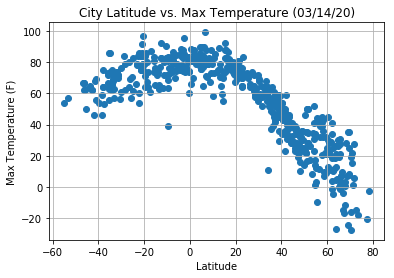

In [92]:
# Set x and y values
x_values=Summary["Lat"]
y_values=Summary["Max Temp"]

# Build plot
plt.scatter(x_values, y_values)

# Set title and axis labels
plt.title(f"City Latitude vs. Max Temperature ({formatted_date})")
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")

# Add grid
plt.grid()

# Create figure and export
fig4 = plt.gcf()
fig4.savefig("Output/Figures/Global_Latitude_vs_Temp.png")

# Show plot
plt.show()


#### Latitude vs. Humidity Plot

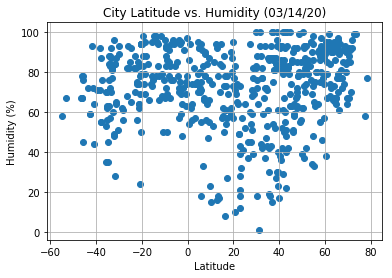

In [93]:
# Set x and y values
x_values=Summary["Lat"]
y_values=Summary["Humidity"]

# Build plot
plt.scatter(x_values, y_values)

# Set title and axis labels
plt.title(f"City Latitude vs. Humidity ({formatted_date})")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")

# Add grid
plt.grid()

# Create figure and export
fig4 = plt.gcf()
fig4.savefig("Output/Figures/Global_Latitude_vs_Humidity.png")

# Show plot
plt.show()

#### Latitude vs. Cloudiness Plot

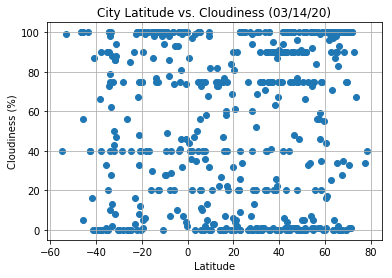

In [94]:
# Set x and y values
x_values=Summary["Lat"]
y_values=Summary["Cloudiness"]

# Build plot
plt.scatter(x_values, y_values)

# Set title and axis labels
plt.title(f"City Latitude vs. Cloudiness ({formatted_date})")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")

# Add grid
plt.grid()

# Create figure and export
fig4 = plt.gcf()
fig4.savefig("Output/Figures/Global_Latitude_vs_Cloud.png")

# Show plot
plt.show()

#### Latitude vs. Wind Speed Plot

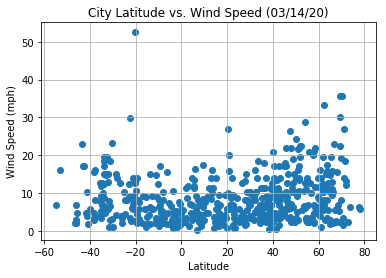

In [95]:
# Set x and y values
x_values=Summary["Lat"]
y_values=Summary["Wind Speed"]

# Build plot
plt.scatter(x_values, y_values)

# Set title and axis labels
plt.title(f"City Latitude vs. Wind Speed ({formatted_date})")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")

# Add grid
plt.grid()

# Create figure and export
fig4 = plt.gcf()
fig4.savefig("Output/Figures/Global_Latitude_vs_Wind.png")

# Show plot
plt.show()

## Linear Regression

In [141]:
# OPTIONAL: Create a function to create Linear Regression plots
def regression_plot(latitude, weather):
    # Calculate the correlation coefficient and linear regression model for mouse weight and average tumor volume for the Capomulin regimen

    # Set x and y values of scatterplot
    x_values = latitude
    y_values = weather

    # Apply linear regression formula. Set line of linear regression.
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept

    # Write equation of regression line
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
        
    return  plt.plot(x_values,regress_values,"r-"), plt.annotate(line_eq, (10,100), fontsize=15, color="red", xycoords="axes points")

In [142]:
# Create Northern and Southern Hemisphere DataFrames
northern = Summary.loc[(Summary["Lat"]>0),:]
southern = Summary.loc[(Summary["Lat"]<0),:]

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

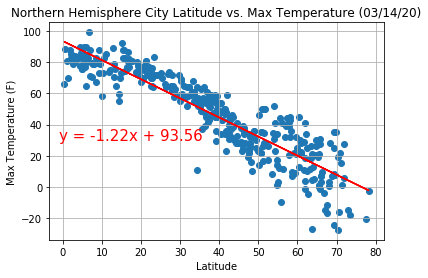

In [143]:
# Set x and y values
x_values=northern["Lat"]
y_values=northern["Max Temp"]

# Build plot
plt.scatter(x_values, y_values)

# Set title and axis labels
plt.title(f"Northern Hemisphere City Latitude vs. Max Temperature ({formatted_date})")
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")

# Add grid
plt.grid()

# Show equation for linear regression line
regression_plot(x_values, y_values)

# Create figure and export
fig4 = plt.gcf()
fig4.savefig("Output/Figures/North_Latitude_vs_Temp.png")

# Show plot
plt.show()

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

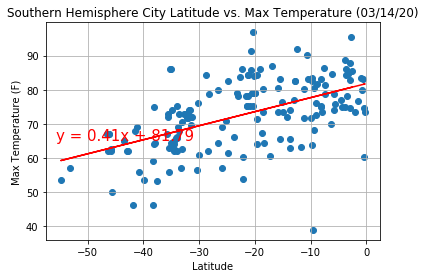

In [144]:
# Set x and y values
x_values=southern["Lat"]
y_values=southern["Max Temp"]

# Build plot
plt.scatter(x_values, y_values)

# Set title and axis labels
plt.title(f"Southern Hemisphere City Latitude vs. Max Temperature ({formatted_date})")
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")

# Add grid
plt.grid()

# Show equation for linear regression line
regression_plot(x_values, y_values)

# Create figure and export
fig4 = plt.gcf()
fig4.savefig("Output/Figures/South_Latitude_vs_Temp.png")

# Show plot
plt.show()

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

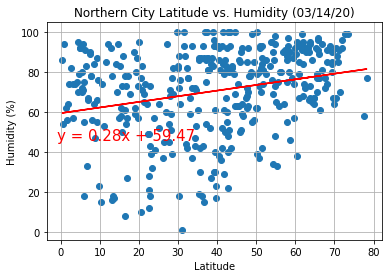

In [145]:
# Set x and y values
x_values=northern["Lat"]
y_values=northern["Humidity"]

# Build plot
plt.scatter(x_values, y_values)

# Set title and axis labels
plt.title(f"Northern City Latitude vs. Humidity ({formatted_date})")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")

# Add grid
plt.grid()

# Show equation for linear regression line
regression_plot(x_values, y_values)

# Create figure and export
fig4 = plt.gcf()
fig4.savefig("Output/Figures/North_Latitude_vs_Humidity.png")

# Show plot
plt.show()

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

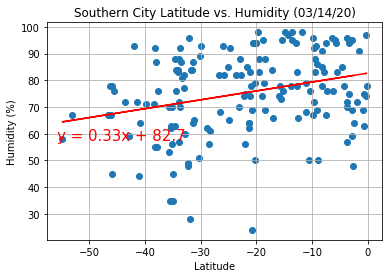

In [146]:
# Set x and y values
x_values=southern["Lat"]
y_values=southern["Humidity"]

# Build plot
plt.scatter(x_values, y_values)

# Set title and axis labels
plt.title(f"Southern City Latitude vs. Humidity ({formatted_date})")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")

# Add grid
plt.grid()

# Show equation for linear regression line
regression_plot(x_values, y_values)

# Create figure and export
fig4 = plt.gcf()
fig4.savefig("Output/Figures/North_Latitude_vs_Humidity.png")

# Show plot
plt.show()

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

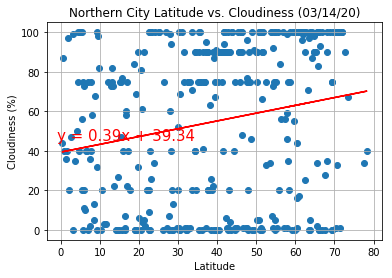

In [147]:
# Set x and y values
x_values=northern["Lat"]
y_values=northern["Cloudiness"]

# Build plot
plt.scatter(x_values, y_values)

# Set title and axis labels
plt.title(f"Northern City Latitude vs. Cloudiness ({formatted_date})")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")

# Add grid
plt.grid()

# Show equation for linear regression line
regression_plot(x_values, y_values)

# Create figure and export
fig4 = plt.gcf()
fig4.savefig("Output/Figures/North_Latitude_vs_Cloud.png")

# Show plot
plt.show()

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

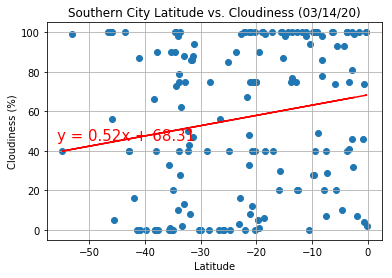

In [148]:
# Set x and y values
x_values=southern["Lat"]
y_values=southern["Cloudiness"]

# Build plot
plt.scatter(x_values, y_values)

# Set title and axis labels
plt.title(f"Southern City Latitude vs. Cloudiness ({formatted_date})")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")

# Add grid
plt.grid()

# Show equation for linear regression line
regression_plot(x_values, y_values)

# Create figure and export
fig4 = plt.gcf()
fig4.savefig("Output/Figures/South_Latitude_vs_Cloud.png")

# Show plot
plt.show()

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

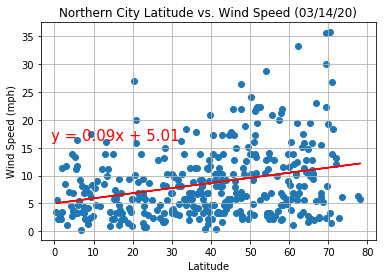

In [149]:
# Set x and y values
x_values=northern["Lat"]
y_values=northern["Wind Speed"]

# Build plot
plt.scatter(x_values, y_values)

# Set title and axis labels
plt.title(f"Northern City Latitude vs. Wind Speed ({formatted_date})")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")

# Add grid
plt.grid()

# Show equation for linear regression line
regression_plot(x_values, y_values)

# Create figure and export
fig4 = plt.gcf()
fig4.savefig("Output/Figures/Northern_Latitude_vs_Wind.png")

# Show plot
plt.show()

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

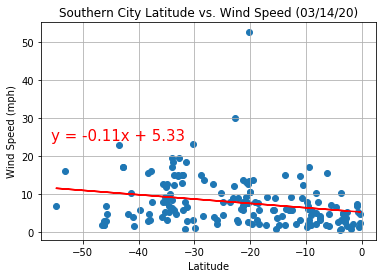

In [150]:
# Set x and y values
x_values=southern["Lat"]
y_values=southern["Wind Speed"]

# Build plot
plt.scatter(x_values, y_values)

# Set title and axis labels
plt.title(f"Southern City Latitude vs. Wind Speed ({formatted_date})")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")

# Add grid
plt.grid()

# Show equation for linear regression line
regression_plot(x_values, y_values)

# Create figure and export
fig4 = plt.gcf()
fig4.savefig("Output/Figures/Southern_Latitude_vs_Wind.png")

# Show plot
plt.show()